In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 

import sys
sys.path.append(f'/media/beans/ssd/bespoke')
from constants import *

import matplotlib.pyplot as plt
from viz_utils import draw_wps
from blender_dataloader import *
from constants import *
from imports import *
from train_utils import get_torque

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [3]:
for i in range(200):
    print(get_obs_per_sec())
    time.sleep(20)

0.0
0.0
24.897259
68.22242
85.80776
116.52924
116.52924
116.52924
116.52924
106.88778
110.47191
112.38735
114.259445
114.259445
116.86535
125.87474
128.08057
127.07269
127.07269
128.00423
127.52533
125.1436
123.278725
121.2175
120.97829
123.32096
130.82695
132.53001
127.70237
128.03041
127.58003
130.85439
128.29613
132.54825
129.04562
128.32724
125.07385
125.3332
125.3332
126.12595
133.40863
133.73454
132.05692
131.77176
129.77321
127.61454
127.61454
117.61778
115.4584
111.3281
107.36957
103.17955
105.202194
109.92473
115.151535
115.35633
122.41299
122.88022
129.48036
125.923615
125.923615
125.32425
124.541626
116.69061
116.69061
116.69061
126.0295
122.649826
124.36479
125.304016
124.831604
122.398895
117.523575
108.01819
109.40002
116.19344
116.19344
124.01234
127.5529
132.86464
129.869
127.8954
123.90793
118.67347
118.67347
115.1065
122.985466
121.17042
115.60749
113.61227
111.89536
113.216736
113.216736
115.72348
121.52076
118.04653
120.41845
119.75008
115.43232
107.46906
103.48469


KeyboardInterrupt: 

In [2]:
get_obs_per_sec()

93.95235

In [3]:
set_should_stop(True)

In [40]:
dataloader = BlenderDataloader("trn", 32)

In [41]:
dataloader.get_obs_per_second()

128.71861

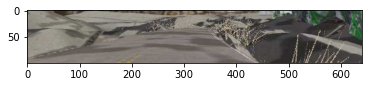

In [42]:
ix = 1
plt.imshow(dataloader.img_chunk[ix][0])

(array([  67.,  110.,  715., 1400.,  852.,  326.,  138.,   95.,    2.,
           7.]),
 array([15.670138, 22.04452 , 28.4189  , 34.79328 , 41.167664, 47.54204 ,
        53.916424, 60.290806, 66.665184, 73.039566, 79.41395 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

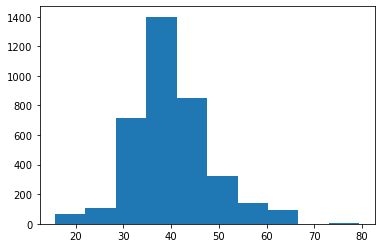

In [43]:
plt.hist(dataloader.aux_chunk[:,:,2].flatten())

(array([  35.,   22.,  609., 1397., 1464.,  108.,   15.,   10.,   12.,
          40.]),
 array([-0.3510493 , -0.25597796, -0.1609066 , -0.06583525,  0.0292361 ,
         0.12430745,  0.2193788 ,  0.31445014,  0.40952152,  0.50459284,
         0.5996642 ], dtype=float32),
 <BarContainer object of 10 artists>)

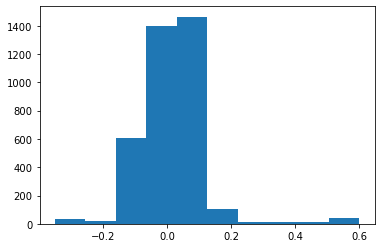

In [44]:
plt.hist(dataloader.targets_chunk[:,:,14].flatten())

In [45]:
%%time
batch, is_first_in_seq = dataloader.get_batch()

(img, 
                                    aux, 
                                    targets,
                                     to_pred_mask,
                                    current_tire_angles_rad, # Extras
                                    current_speeds_mps, 
                                    pitch, 
                                    yaw) = batch

is_first_in_seq

CPU times: user 423 µs, sys: 60 µs, total: 483 µs
Wall time: 560 µs


True

(array([1300., 1300., 1137.,  275.,  173.,    3.,   13.,   21.,   32.,
          66.]),
 array([-1.313, -0.523,  0.268,  1.059,  1.85 ,  2.64 ,  3.432,  4.223,
         5.01 ,  5.805,  6.594], dtype=float16),
 <BarContainer object of 10 artists>)

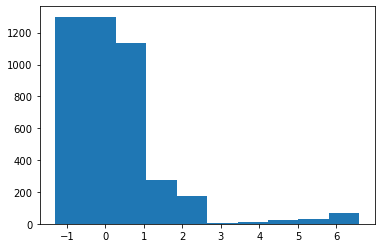

In [46]:
plt.hist(targets.flatten().detach().cpu().numpy())

In [47]:
to_pred_mask.sum() / to_pred_mask.numel()

tensor(0.9609, device='cuda:0', dtype=torch.float16)

(array([19., 25., 30., 64.,  6.,  7.,  4., 35., 52., 46.]),
 array([-3904. , -3194. , -2482. , -1772. , -1061. ,  -350. ,   360.8,
         1072. ,  1782. ,  2494. ,  3204. ], dtype=float16),
 <BarContainer object of 10 artists>)

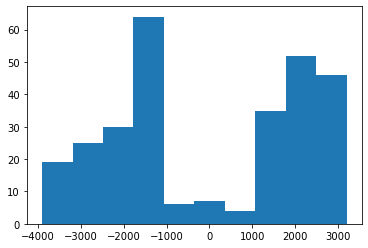

In [48]:
t = get_torque(targets, aux)
plt.hist(t.cpu().numpy().flatten())

In [49]:
abs(t).max()

tensor(3904., device='cuda:0', dtype=torch.float16)

(array([161.,  60.,  19.,   8.,   4.,   2.,   1.,   0.,   0.,   1.]),
 array([  0. ,  62.6, 125.2, 187.8, 250.4, 313. , 375.5, 438.2, 500.8,
        563.5, 626. ], dtype=float16),
 <BarContainer object of 10 artists>)

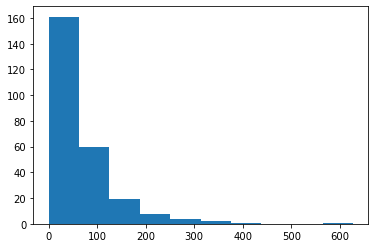

In [50]:
td = abs(t[:,1:,:] - t[:,:-1,:])
plt.hist(td.cpu().numpy().flatten())

In [51]:
abs(td).max()

tensor(626., device='cuda:0', dtype=torch.float16)

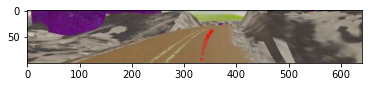

In [67]:

traj = dataloader.targets_chunk[ix][0]
img = dataloader.img_chunk[ix][0]

plt.imshow(draw_wps(img, traj))

In [8]:
import subprocess

In [9]:
# Load up membank from ssd to shm
subprocess.run("cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank", shell=True)

CompletedProcess(args='cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank', returncode=0)

In [ ]:
# save membank to ssd
subprocess.run("cp -R /dev/shm/blender_membank /media/beans/beans_data/blender_membank", shell=True)